In [2]:
import os
import ast
import glob
import numpy as np
import pandas as pd
import pysgpp as pysgpp
import seaborn as sns

from sklearn.model_selection import train_test_split

from pysgpp.extensions.datadriven.learner import Types
from pysgpp.extensions.datadriven.learner import LearnerBuilder
from pysgpp.extensions.datadriven.uq.plot.plot1d import plotSG1d
from pysgpp.extensions.datadriven.uq.plot.plot2d import plotSG2d,plotGrid2d
from pysgpp.extensions.datadriven.uq.plot.plot3d import plotSG3d
from pysgpp.extensions.datadriven.uq.plot.plotGrid import plotGrid
from pysgpp.extensions.datadriven.learner.folding import RandomFoldingPolicy

import matplotlib.pyplot as plt
from sklearn import preprocessing

plt.style.use('ggplot')
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

Populating the interactive namespace from numpy and matplotlib


In [3]:
def parse_times(filename):
    df = pd.read_csv(filename, header = None, names = ['params', 'time'])
    df.params = df.params.apply(ast.literal_eval)
    for param in df.iloc[0].params.keys():
        df[param] = df.params.apply(lambda row: row[param])
    df['density'] = (df.MOL_X*df.MOL_Y)/(df.DOMAIN_SIZE_X*df.DOMAIN_SIZE_Y)
    del df['params']
    return df

# combine all the data frames we have in the data/* dir
#dfList = map(parse_times, glob.glob('data/*.csv'))
#df = reduce(lambda x, y: x.append(y), dfList)
df = parse_times('data/07_02_2018_1500_runs.csv')

In [4]:
df.head(15)

,time,CHECKPOINT,TEMP,DOMAIN_SIZE_Y,DELTA_T,V_x,V_y,LINKED_CELL_SIZE_Y,LINKED_CELL_SIZE_X,DOMAIN_SIZE_X,MOL_X,MOL_Y,CUTOFF_RADIUS,TIMESTEPS,BLOCK_SIZE,density
0,6.884722,checkpoints/IFINP54KR7_999,2.5,35,0.002,1,1.5,5.00,5.00,60,50,20,3.0,1000,100,0.476190
1,4.645518,checkpoints/1KXPSLV7A9_999,2.5,45,0.002,1,1.5,2.50,5.00,60,20,45,1.4,1000,1000,0.333333
2,3.839575,checkpoints/P47B0FAJF4_999,2.5,50,0.002,1,1.5,6.25,3.75,45,35,20,1.4,1000,1000,0.311111
3,7.104349,checkpoints/FD518CWV90_999,2.5,65,0.002,1,1.5,5.00,5.00,60,40,50,1.4,1000,1000,0.512821
4,2.713921,checkpoints/TU73XO27XO_999,2.5,25,0.002,1,1.5,5.00,6.25,50,15,15,1.4,1000,1000,0.180000
5,4.411235,checkpoints/0GY454QIRT_999,2.5,60,0.002,1,1.5,5.00,5.00,30,25,35,2.4,1000,1000,0.486111
6,3.585438,checkpoints/2KYW2IFEWB_999,2.5,60,0.002,1,1.5,5.00,3.75,60,55,15,3.0,1000,100,0.229167
7,3.379033,checkpoints/D48NIKI2O7_999,2.5,35,0.002,1,1.5,5.00,5.00,60,20,25,2.2,1000,1000,0.238095
8,9.597648,checkpoints/KGPXXHQSXE_999,2.5,50,0.002,1,1.5,5.00,3.75,45,40,50,2.0,1000,10000,0.888889
9,4.692324,checkpoints/SWMOXHBH10_999,2.5,60,0.002,1,1.5,3.75,5.00,60,15,55,3.6,1000,100,0.229167


In [5]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [6]:
columns = ['DOMAIN_SIZE_X', 'DOMAIN_SIZE_Y', 'MOL_X', 'MOL_Y', 'LINKED_CELL_SIZE_X', 'LINKED_CELL_SIZE_Y',
          'BLOCK_SIZE', 'CUTOFF_RADIUS', 'density','time']

params = ['CUTOFF_RADIUS', 'density', 'MOL_Y','MOL_X','DOMAIN_SIZE_Y',
           'DOMAIN_SIZE_X','MOL_X','LINKED_CELL_SIZE_X', 'LINKED_CELL_SIZE_Y']

In [7]:
normalized_df = normalize(df[df.time > 0][columns])
train, test = train_test_split(normalized_df, test_size=0.2)
num_samples = train.shape[0]

In [8]:
columns =['accuracy','level','L2Norm','RMSerror','grid_points','adaptive','train_data',]
results = pd.DataFrame(columns=columns)

In [9]:
for train_data_size in range(100,1201,100):
    print train_data_size
    train_ = train.sample(train_data_size)
    X_train = train_[params].values
    Y_train = train_['time'].values
    X_test = test[params].values
    Y_test = test['time'].values
    for level in range(1,5):
        builder = LearnerBuilder()
        builder.buildRegressor()
        builder.withTrainingDataFromNumPyArray(X_train, Y_train)
        builder.withTestingDataFromNumPyArray(X_test, Y_test)
        builder = builder.withGrid().withBorder(Types.BorderTypes.NONE)
        builder.withLevel(level)
        builder = builder.withSpecification()
        builder.withLambda(0.000001)

        #builder.withRandomFoldingPolicy().withLevel(4)

        builder.withIdentityOperator()
        builder = builder.withStopPolicy()
        builder = builder.withCGSolver()
        builder.withAccuracy(0.0001)
        builder.withImax(1000)
        learner = builder.andGetResult()

        #learner.learnData()
        learner.learnDataWithTest()
        #learner.learnDataWithFolding()

        accuracy = learner.testAccuracy[0]
        level = level
        L2Norm = learner.getL2NormError()
        RMSerror = learner.error.RMSNorm()
        grid_points = learner.grid.getSize()
        adaptive = "Level: "+str(level)+" adaptive: 0"
        results = results.append(pd.DataFrame([[accuracy,level,L2Norm,RMSerror,grid_points,adaptive,train_data_size]],columns=columns))

        learner.refineGrid()
        learner.learnData()
        accuracy = learner.testAccuracy[0]
        level = level
        L2Norm = learner.getL2NormError()
        RMSerror = learner.error.RMSNorm()
        grid_points = learner.grid.getSize()
        adaptive = "Level: "+str(level)+" adaptive: 1"
        results = results.append(pd.DataFrame([[accuracy,level,L2Norm,RMSerror,grid_points,adaptive,train_data_size]],columns=columns))




100
200
300
400
500
600
700
800
900
1000
1100
1200


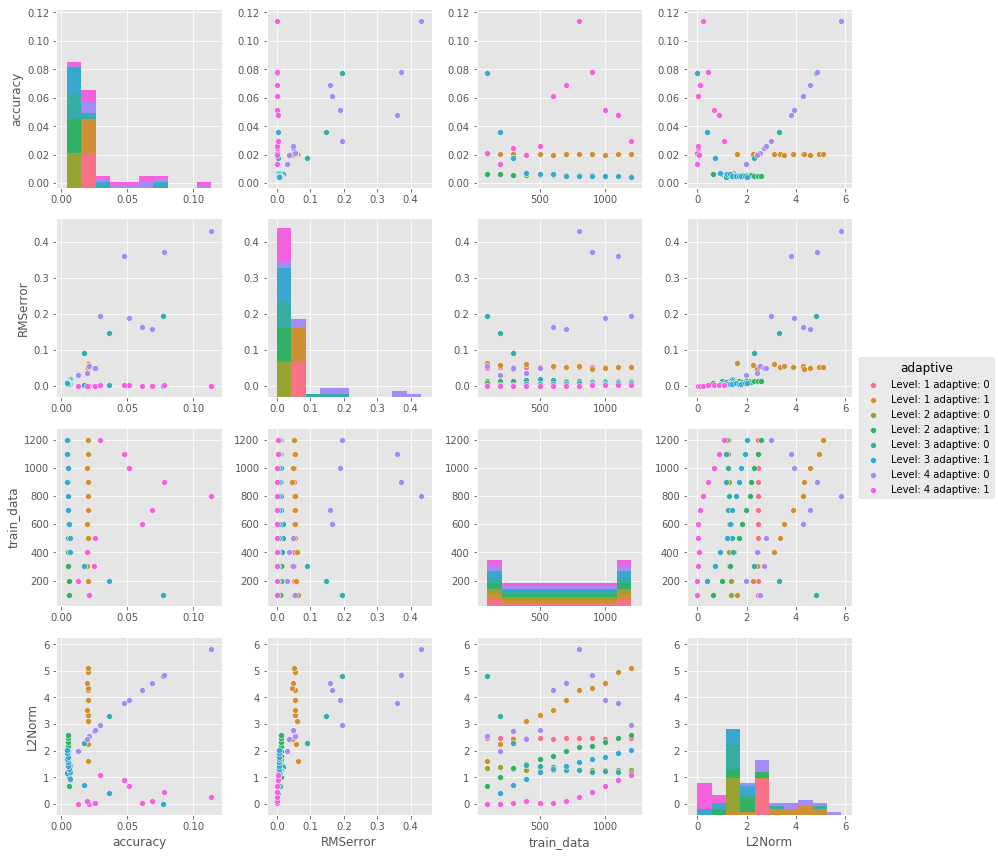

In [10]:
sns.pairplot(results[['accuracy','RMSerror','train_data','L2Norm','adaptive']],hue="adaptive", size=3, aspect=1,palette="husl")

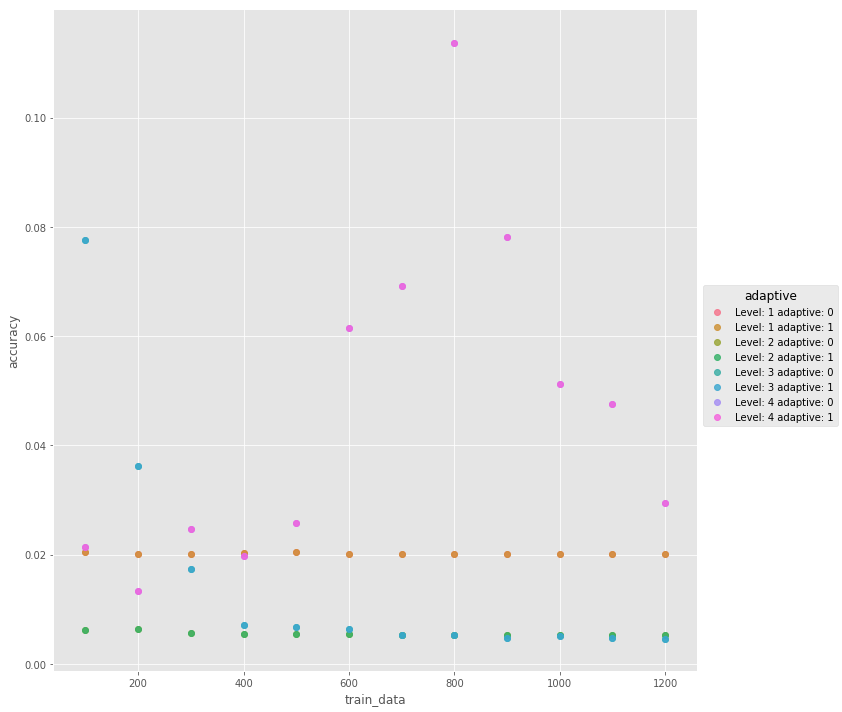

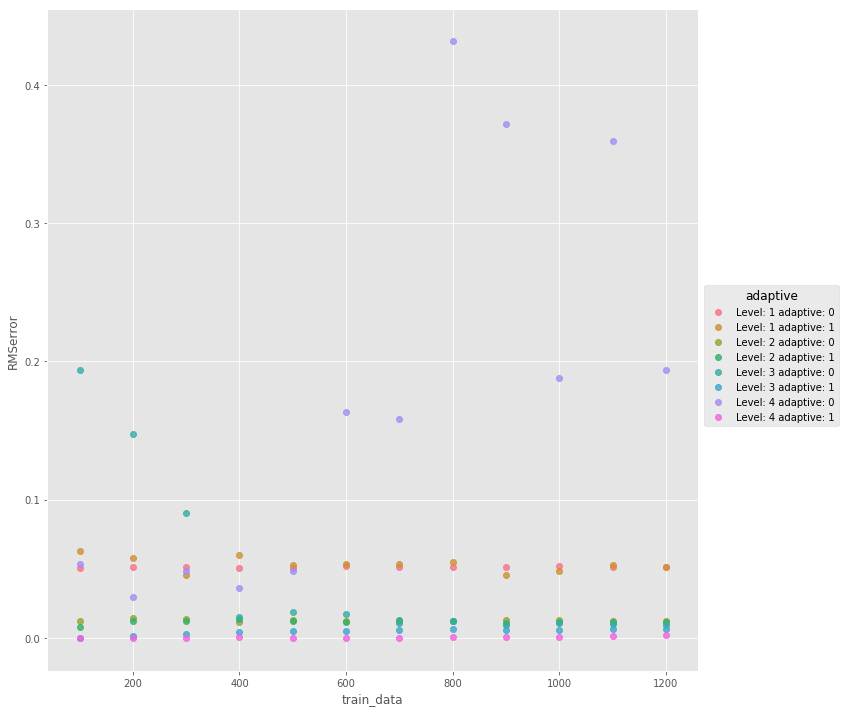

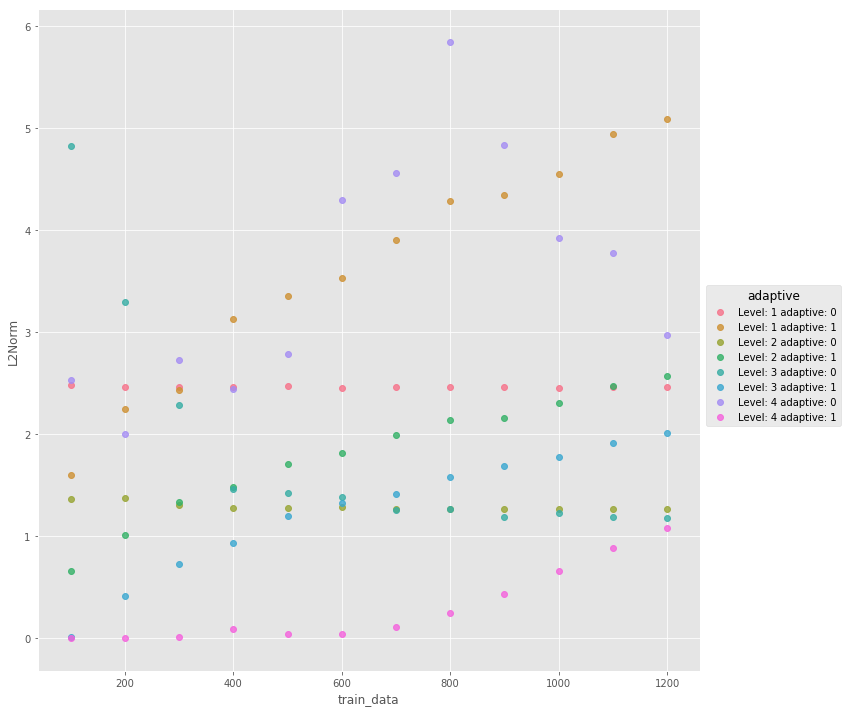

In [12]:
for i in ['accuracy','RMSerror','L2Norm']:
    sns.lmplot('train_data',i, data=results, hue='adaptive', fit_reg=False, size=10, aspect=1,palette="husl")

TypeError: No loop matching the specified signature and casting
was found for ufunc svd_n_s

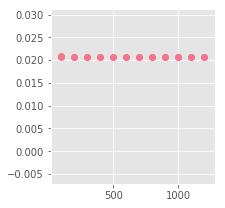

In [159]:
for i in ['accuracy','RMSerror','L2Norm']:
    sns.lmplot('train_data', i , data=results,hue="adaptive", size=3, aspect=1,palette="husl")

In [31]:
X_train = train[params].values
Y_train = train['time'].values

In [32]:
X_test = test[params].values
Y_test = test['time'].values

In [35]:
accuray = []
test_accuracy = []
grid_points = []
levels = []
test_accuracy = []
L2Norm = []
RMSerror = []
adaptive = []

In [36]:
for level in range(1,5):
    builder = LearnerBuilder()
    builder.buildRegressor()
    builder.withTrainingDataFromNumPyArray(X_train, Y_train)
    builder.withTestingDataFromNumPyArray(X_test, Y_test)
    builder = builder.withGrid().withBorder(Types.BorderTypes.NONE)
    builder.withLevel(level)
    builder = builder.withSpecification()
    builder.withLambda(0.000001)

    #builder.withRandomFoldingPolicy().withLevel(4)

    builder.withIdentityOperator()
    builder = builder.withStopPolicy()
    builder = builder.withCGSolver()
    builder.withAccuracy(0.0001)
    builder.withImax(1000)
    learner = builder.andGetResult()

    #learner.learnData()
    learner.learnDataWithTest()
    #learner.learnDataWithFolding()
    
    test_accuracy.append(learner.testAccuracy[0])
    levels.append(level)
    L2Norm.append(learner.getL2NormError())
    RMSerror.append(learner.error.RMSNorm())
    grid_points.append(learner.grid.getSize())
    adaptive.append("Level: "+str(level)+" adaptive: 0")
    learner.refineGrid()
    learner.learnData()
    adaptive.append("Level: "+str(level)+" adaptive: 1")
    test_accuracy.append(learner.testAccuracy[0])
    levels.append(level)
    L2Norm.append(learner.getL2NormError())
    RMSerror.append(learner.error.RMSNorm())
    grid_points.append(learner.grid.getSize())


In [37]:
results = pd.DataFrame({"accuracy":test_accuracy
              , "level" : levels
              , "L2Norm" : L2Norm
              , "RMSerror":RMSerror
              , "adaptive" : adaptive          
              , 'grid_points' : grid_points
              , 'train_data' : train_data})

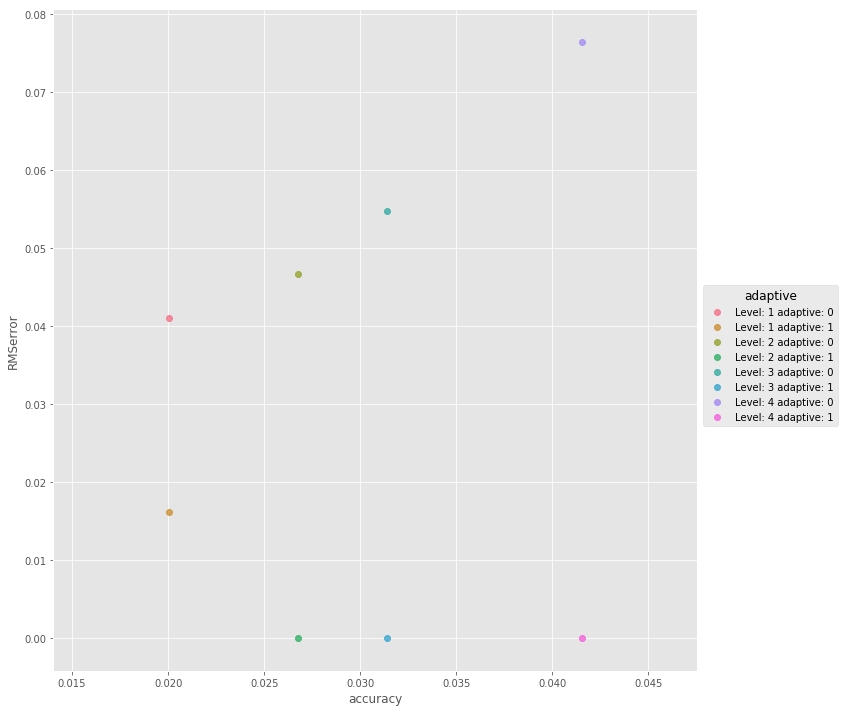

In [38]:
sns.lmplot('accuracy', 'RMSerror', data=results, hue='adaptive', fit_reg=False, size=10, aspect=1)

plt.show()

In [ ]:

    print 'MaxError: %f' % learner.getMaxError()
    print 'MinError: %f' % learner.getMinError()
    #print 'Error: %f' % learner.evalError(learner.dataContainer,learner.alpha)
    print 'RMSerror: %f' % learner.error.RMSNorm()
    print 'Grid size BEFORE refinement: %i' % learner.grid.getSize()
    print 'Refining grid.. '
    
    print 'Grid size AFTER refinement: %i' % learner.grid.getSize()
    print 'Test accuracy:' + str(learner.testAccuracy)
    print 'L2Norm: %f' % learner.getL2NormError()
    print 'MaxError: %f' % learner.getMaxError()
    print 'MinError: %f' % learner.getMinError()
    print 'Error: %f' % learner.evalError(learner.dataContainer,learner.alpha)
    print 'RMSerror: %f' % learner.error.RMSNorm()
    print '--------------------------------------------'

In [ ]:
results = pd.DataFrame(columns=['accuracy','grid_points','level','test_accuracy','L2Norm','RMSerror'])

In [27]:
def generatePairPlots(X, y, grid, alpha, title = '', outdir = None):
    n = X.shape[0]
    time_estimations = []
    p = pysgpp.DataVector(len(params))
    for i in range(n):
        for j, v in enumerate(X[i,]):
            p[j] = v
        opEval = pysgpp.createOperationEval(grid)
        time_estimations.append(opEval.eval(alpha, p))

    for i, p in enumerate(params):
        plt.figure()
        plt.xlabel(p)
        plt.ylabel('time')
        plt.title(title)
        plt.scatter(X[:,i], y, color = 'b')
        sorted_test, sorted_estimations = zip(*sorted(zip(X[:,i], time_estimations)))
        plt.plot(sorted_test, sorted_estimations, color = 'r', linestyle = '-.')
        if outdir:
            plt.savefig(os.path.join(outdir, p + '.png'))

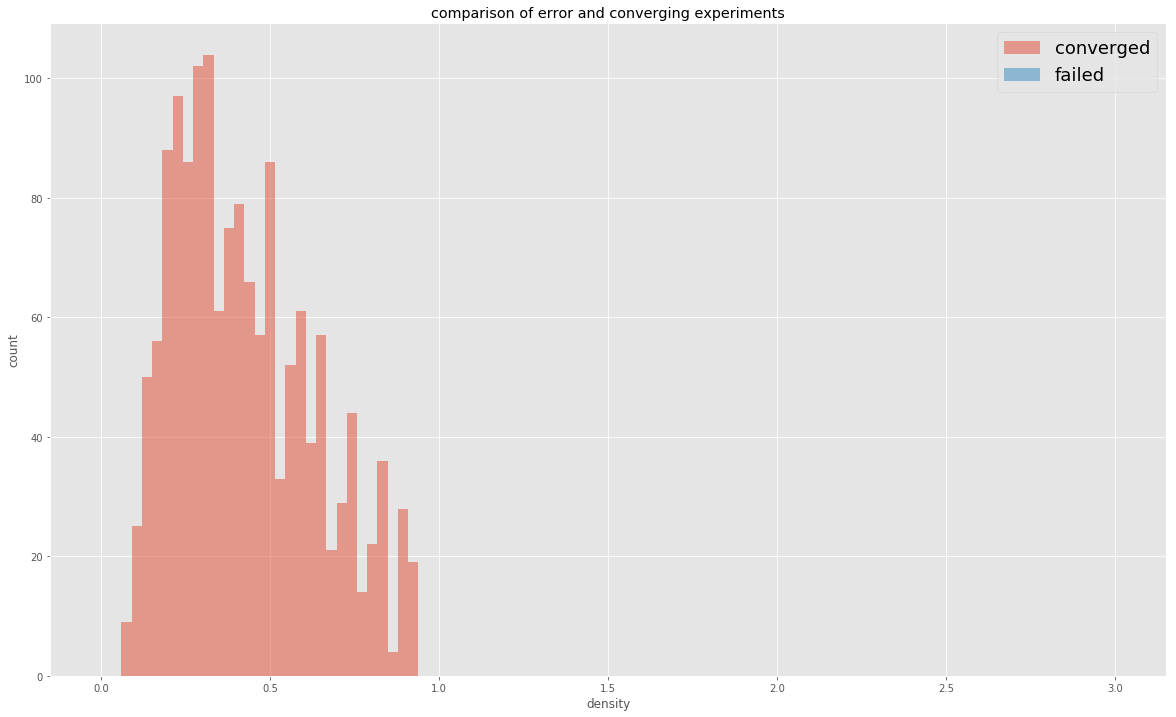

In [5]:
failed = df[df.time.isnull()].density
converged = df[~df.time.isnull()].density

bins = numpy.linspace(0, 3, 100)

plt.hist(converged, bins, alpha=0.5, label='converged')
plt.hist(failed, bins, alpha=0.5, label='failed')
plt.title('comparison of error and converging experiments')
plt.xlabel('density')
plt.ylabel('count')
plt.legend(loc='upper right', prop={'size': 18})
plt.show()

plt.savefig('failures.png')

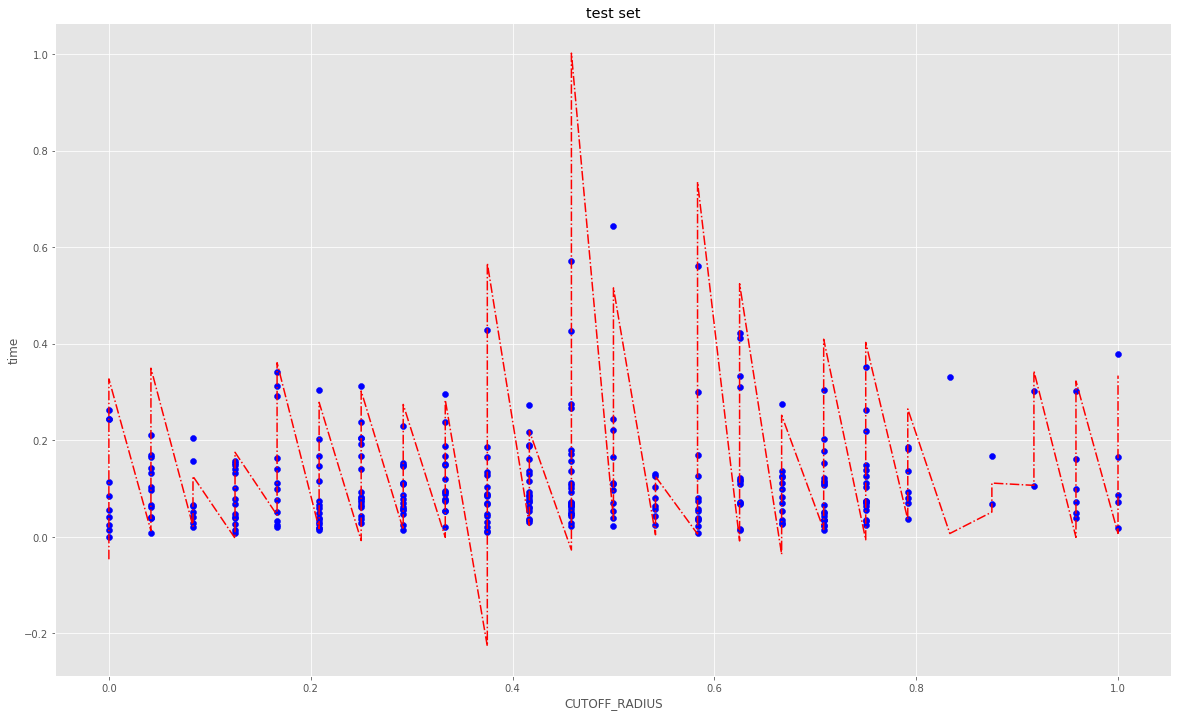

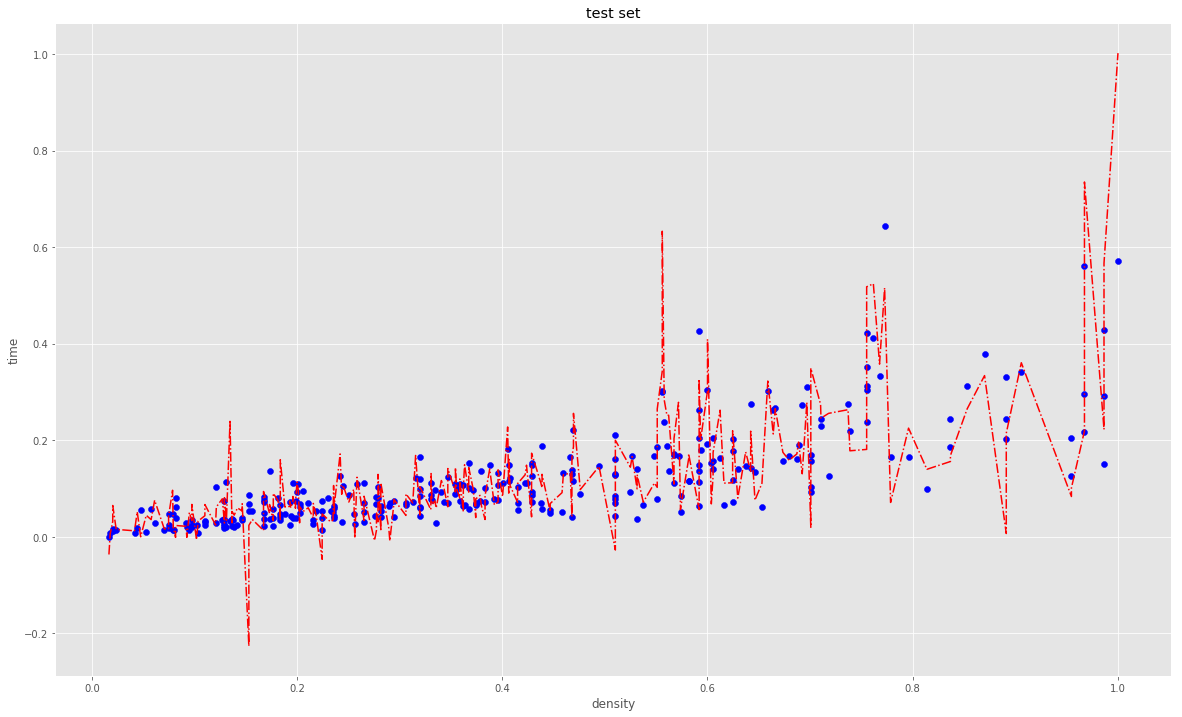

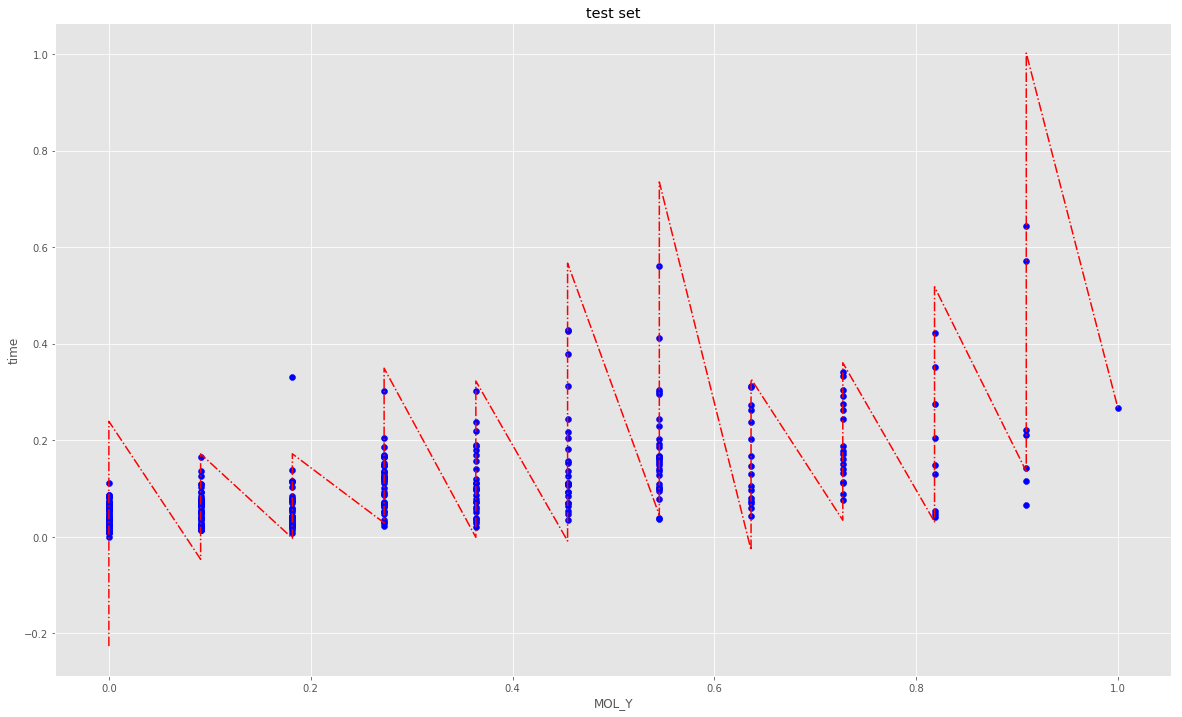

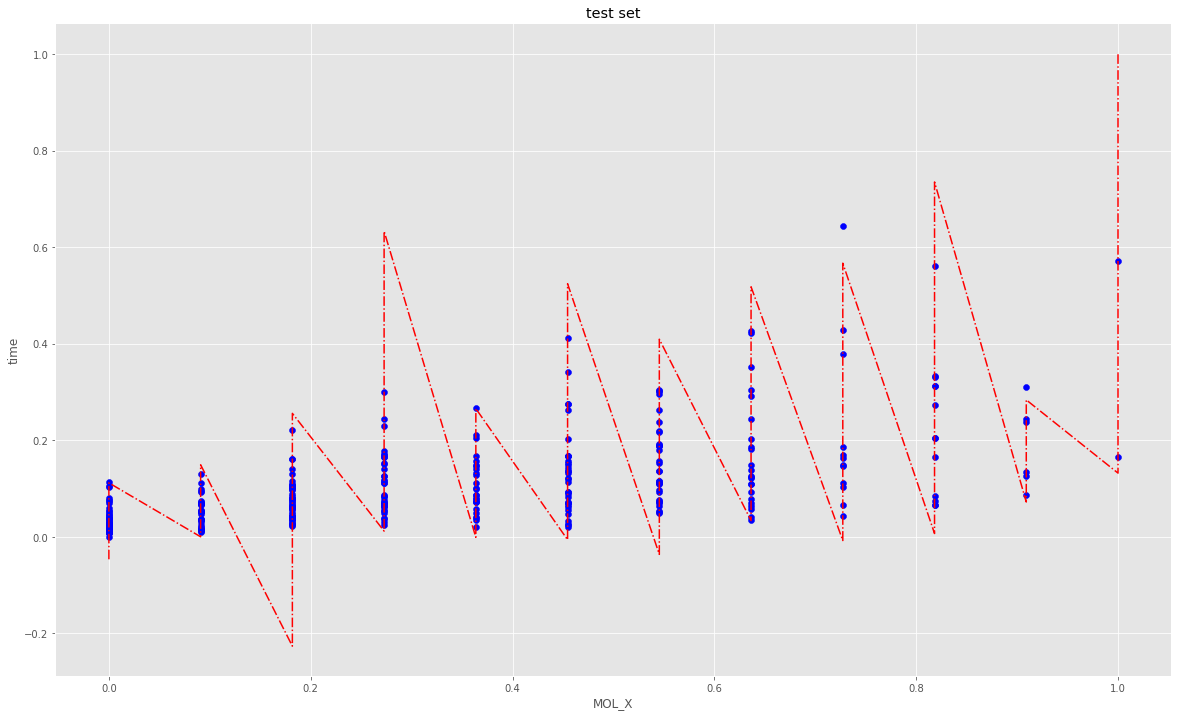

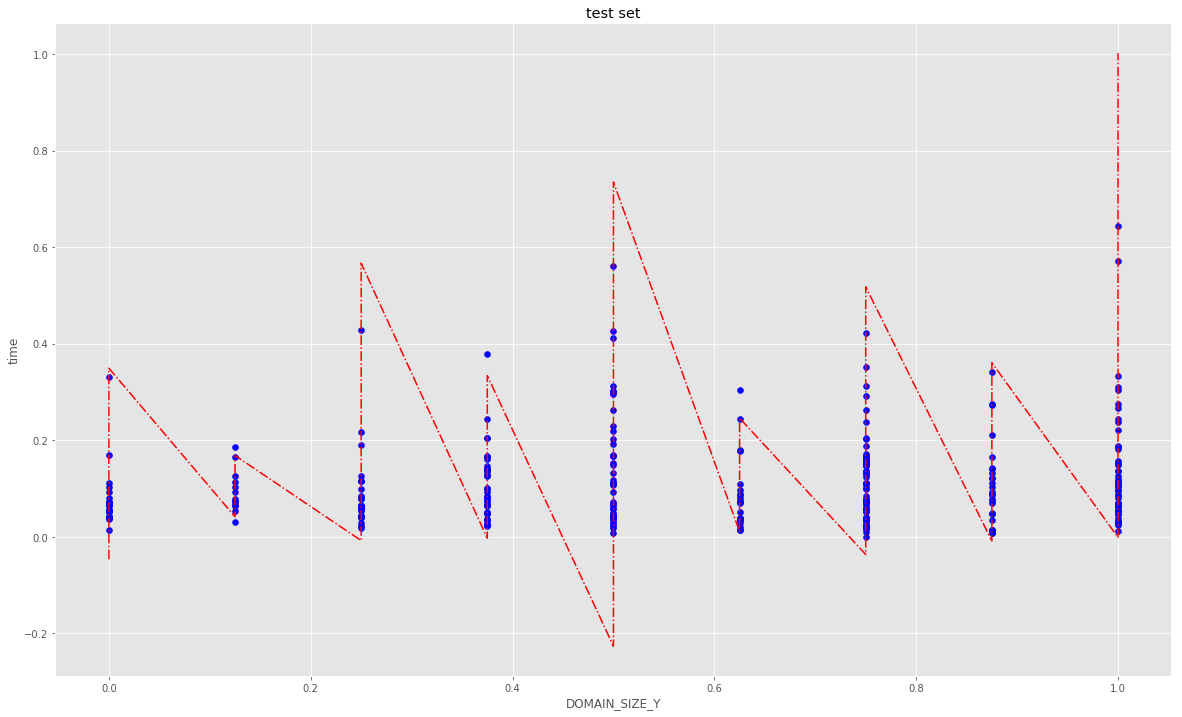

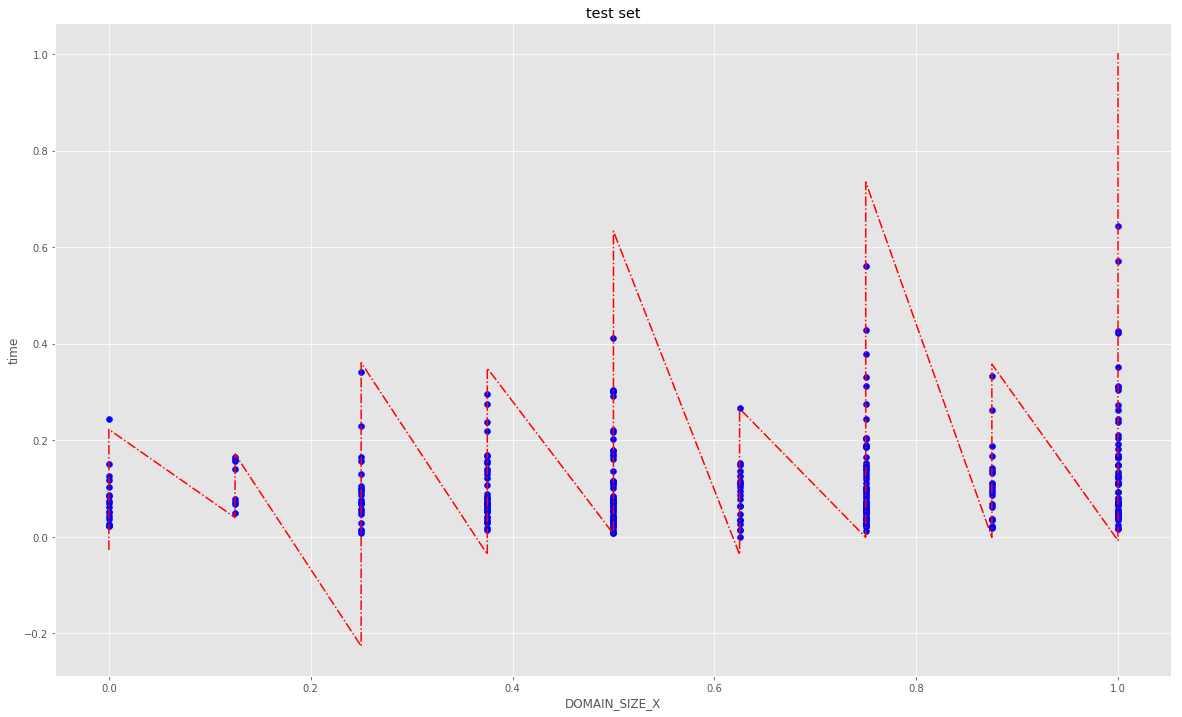

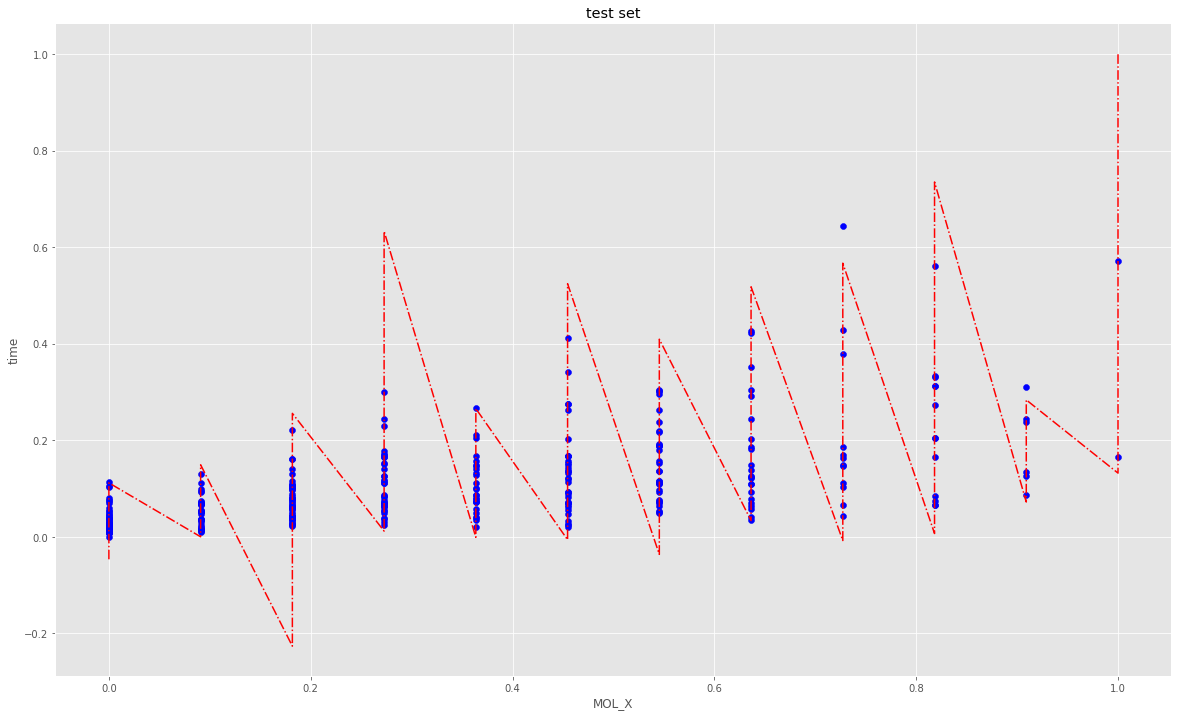

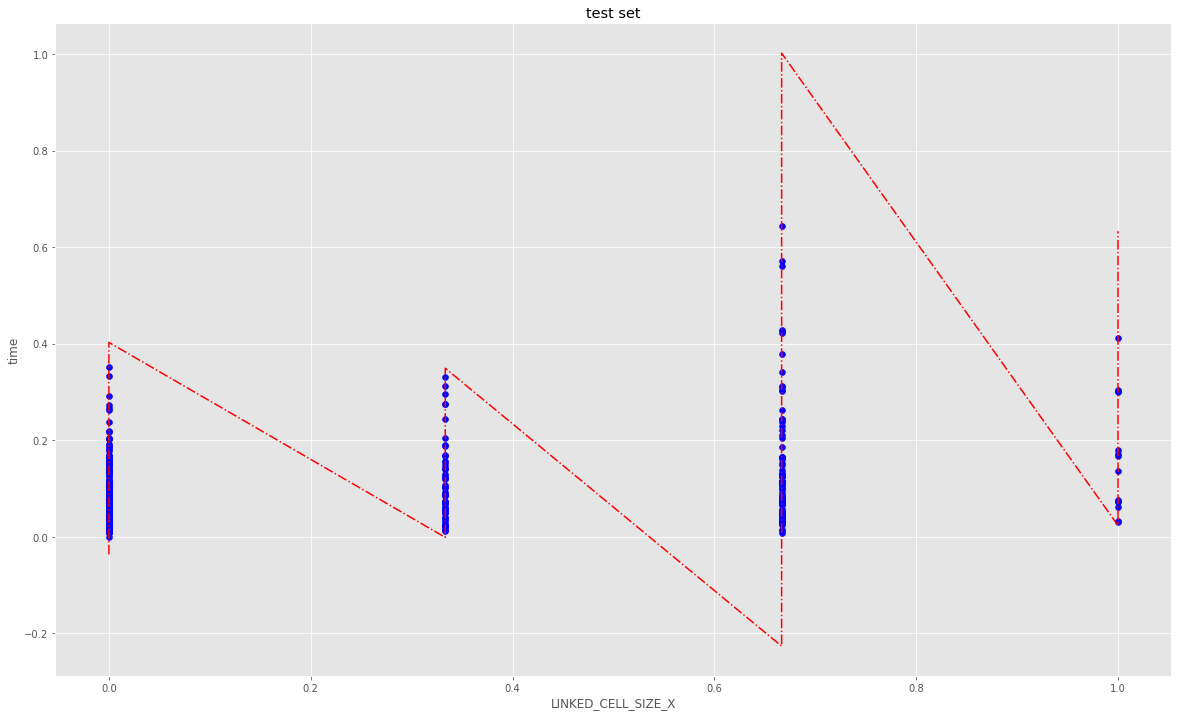

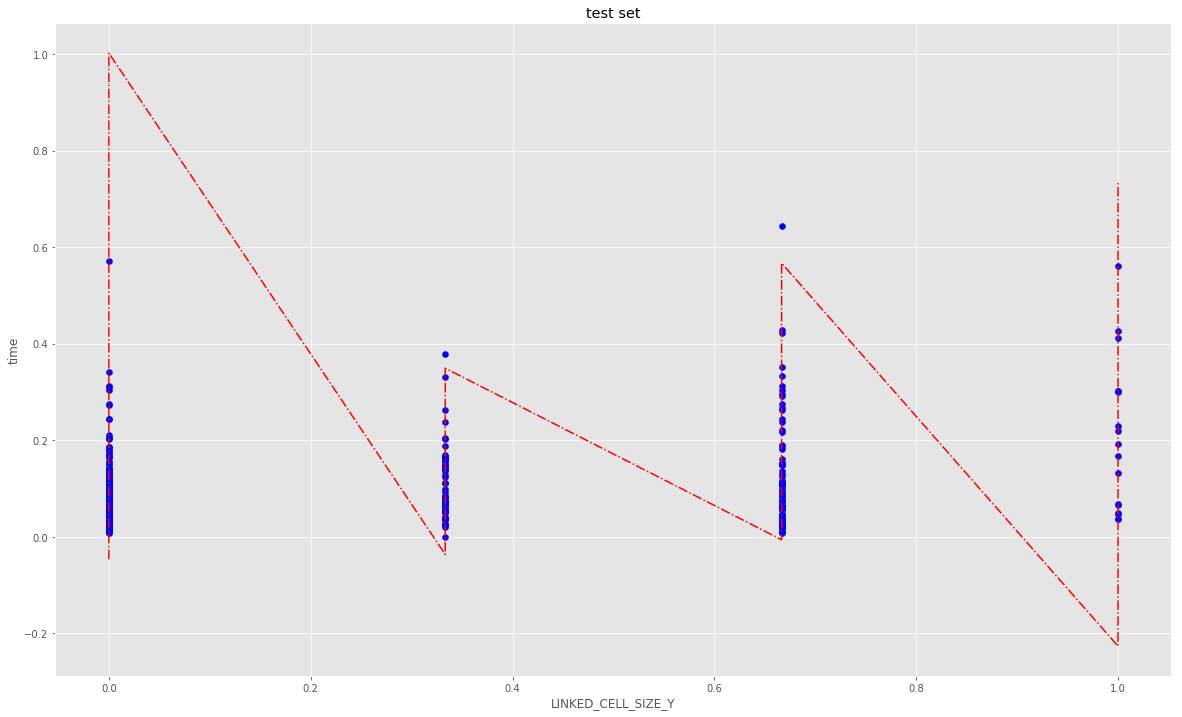

In [30]:
generatePairPlots(X_test, Y_test, learner.grid, learner.alpha, title = 'test set', outdir = '/media/sf_Downloads/sparse_grids/pairPlots/test')

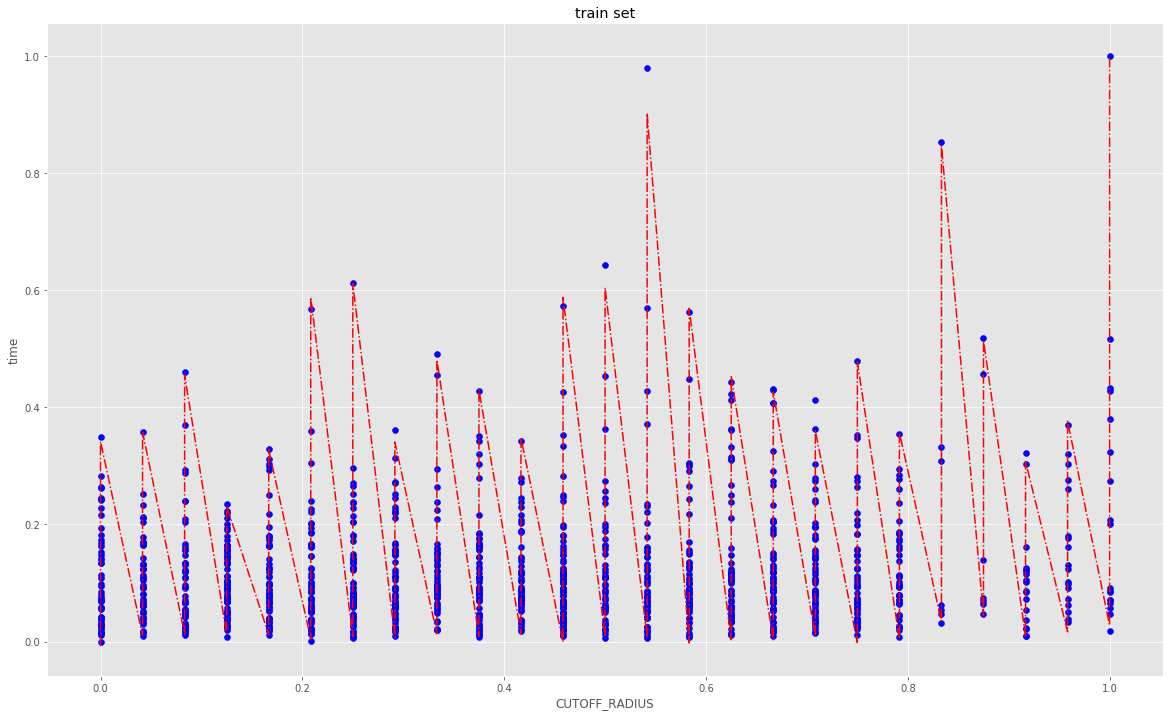

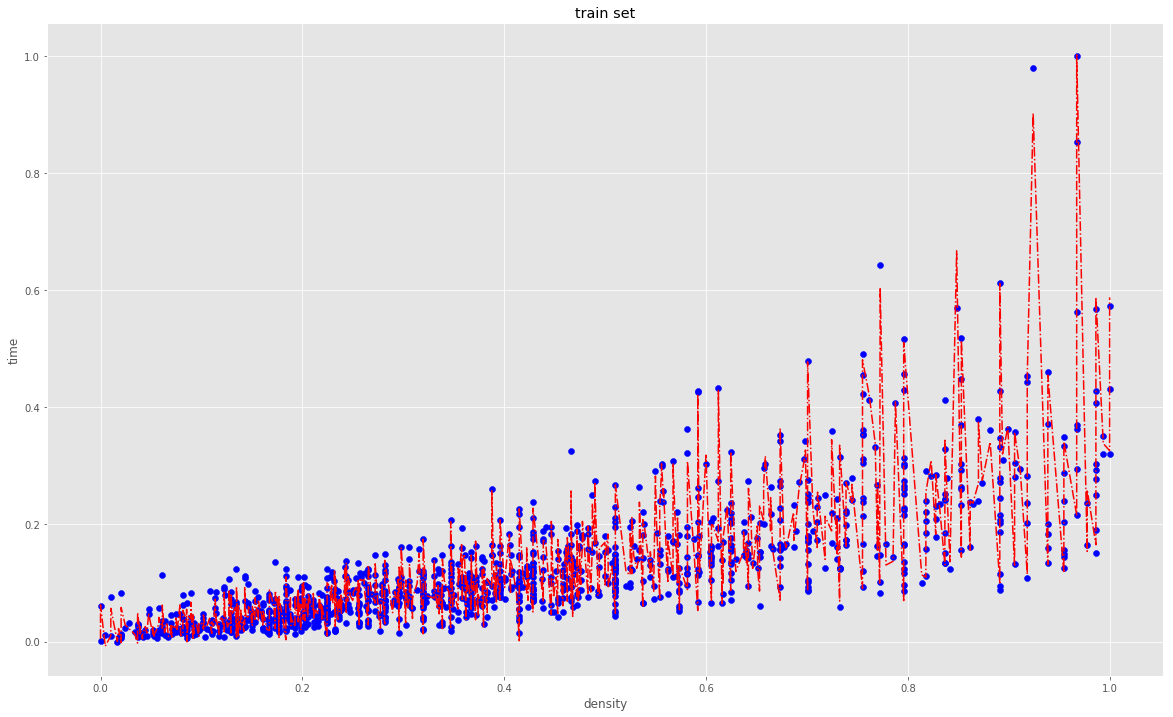

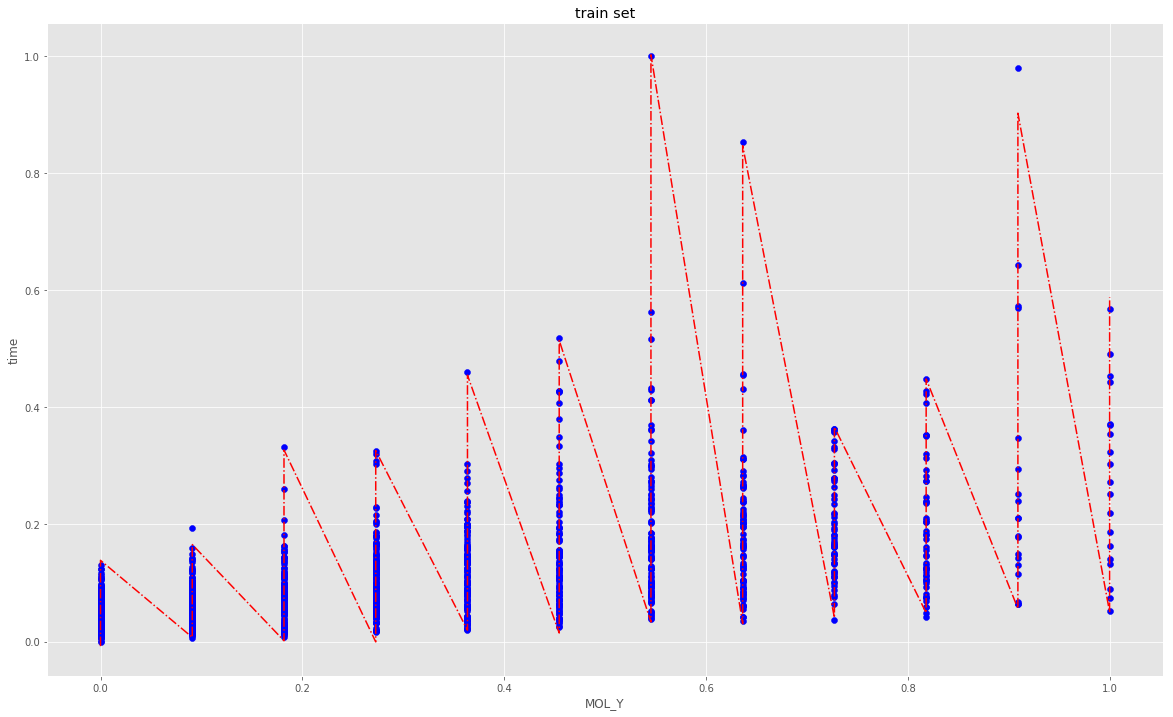

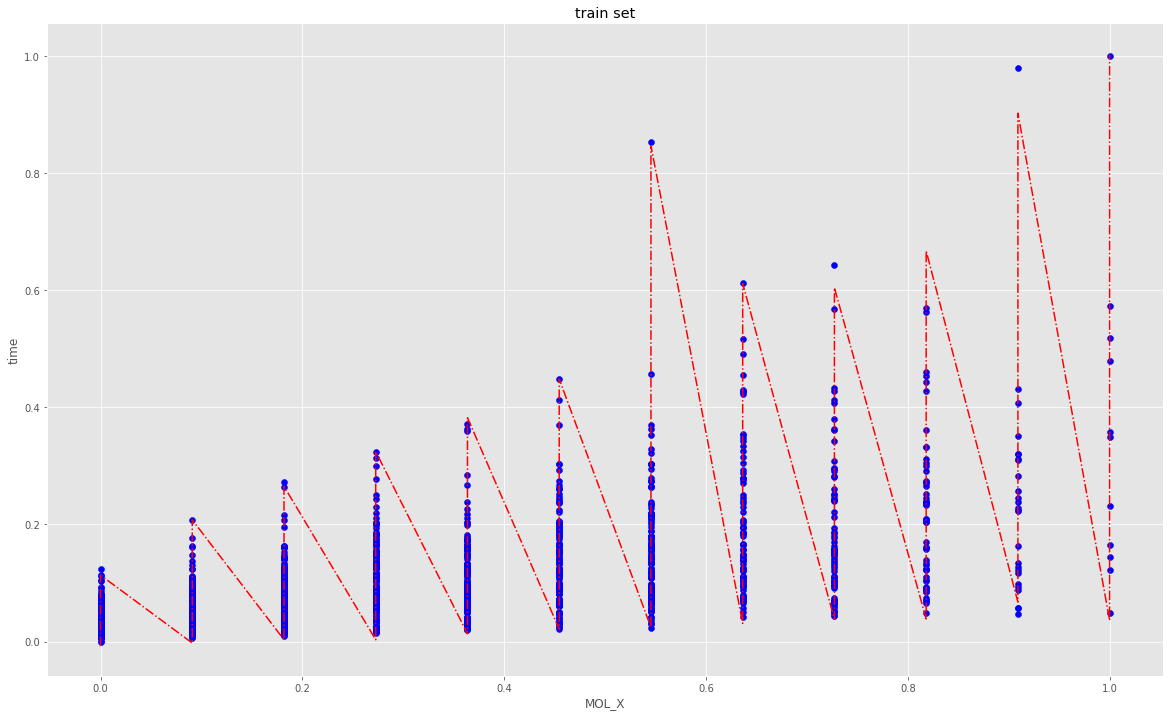

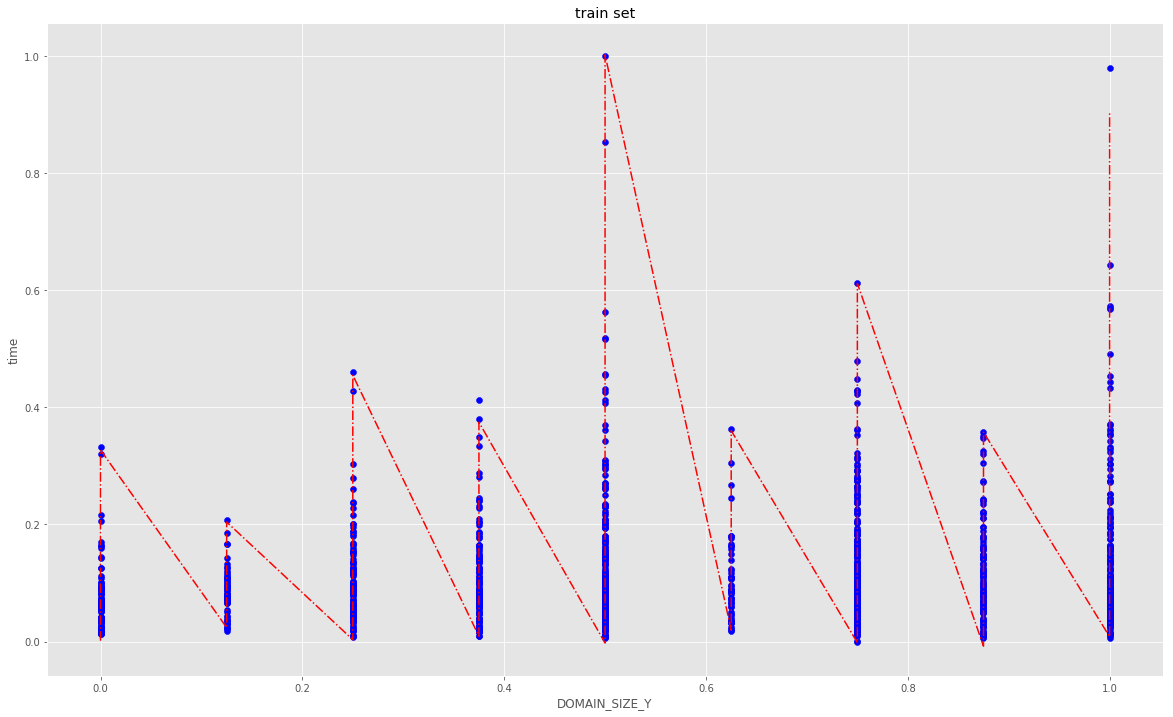

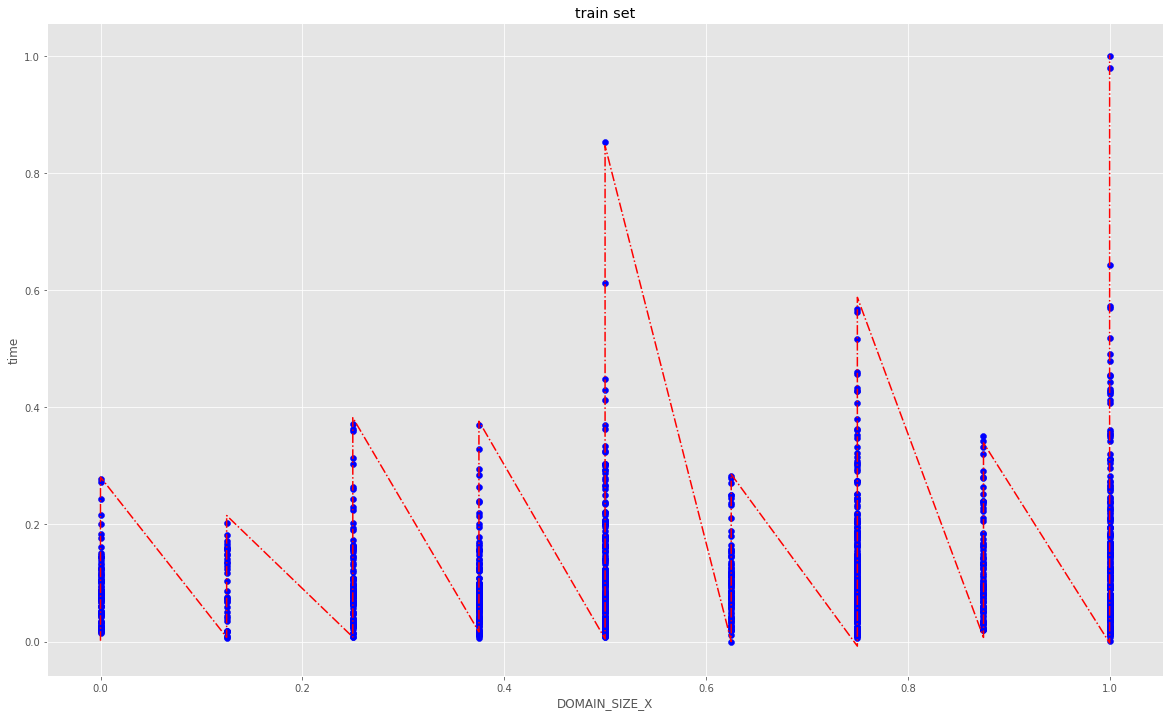

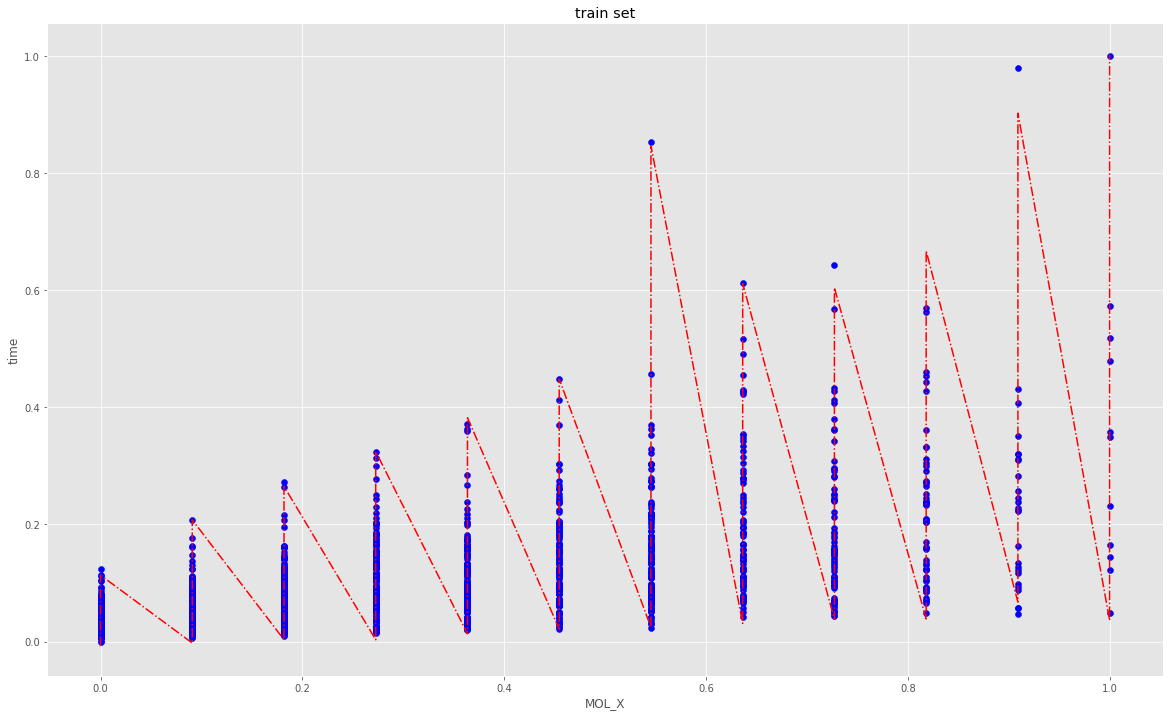

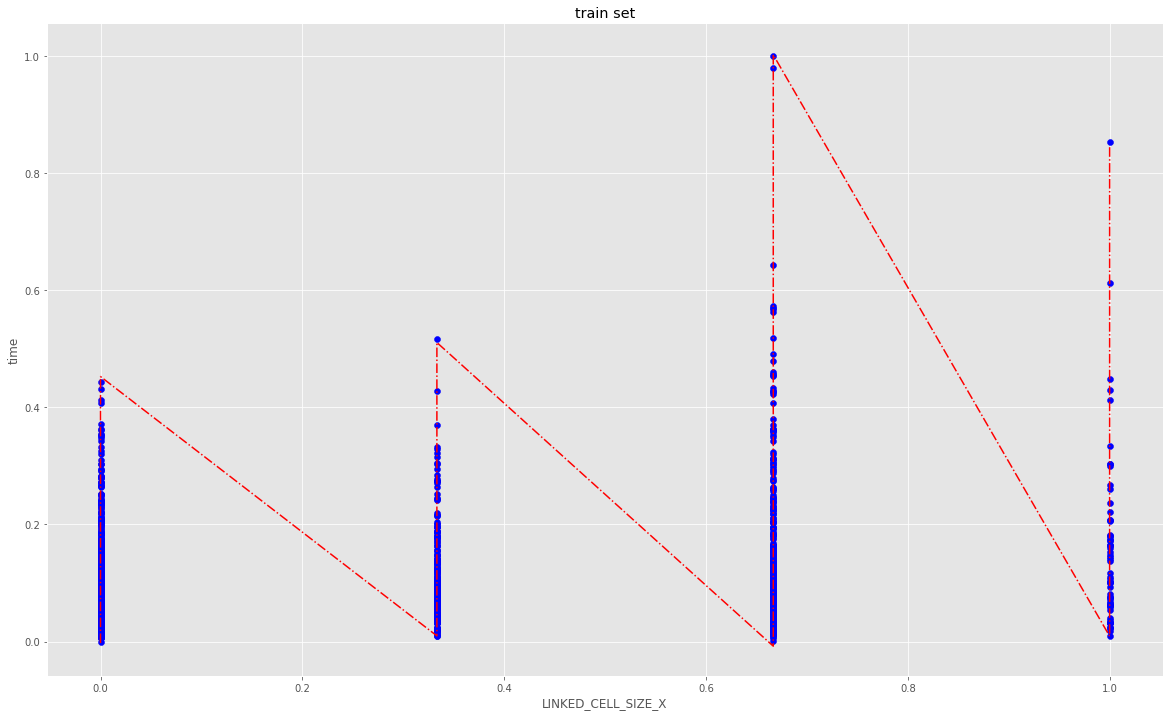

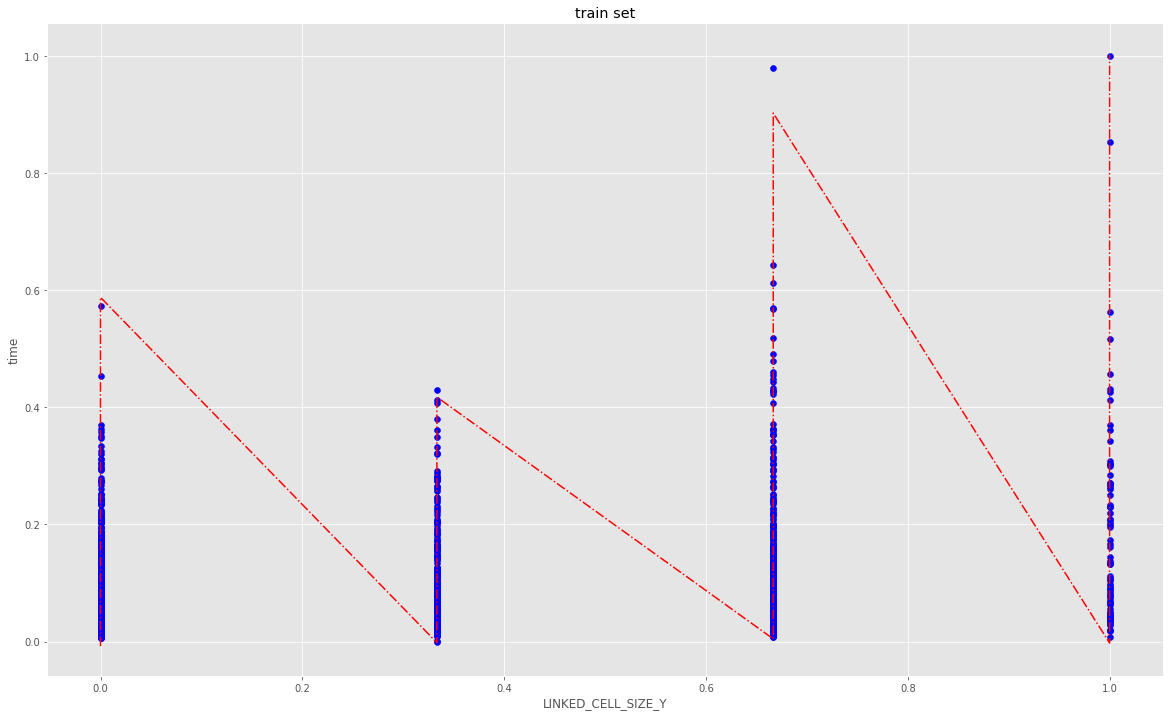

In [16]:
generatePairPlots(X_train, Y_train, learner.grid, learner.alpha, title='train set', outdir = '/media/sf_sparse_grids/pairPlots/train')

In [13]:
# df.to_csv('raw_data_16_1_2018.csv')